In [1]:
import argparse
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy import stats
from scipy import spatial
from utilities import load_data, print_features, print_predictions
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap
from sklearn import neighbors, datasets

%matplotlib inline

plt.rc('figure', figsize=(7, 7), dpi=110)
plt.rc('font', size=10)

# you may use these colours to produce the scatter plots
CLASS_1_C = r'#3366ff'
CLASS_2_C = r'#cc3300'
CLASS_3_C = r'#ffc34d'

class_colours = [CLASS_1_C, CLASS_2_C, CLASS_3_C]

In [11]:
train_set, train_labels, test_set, test_labels = load_data(train_set_path="data/wine_train.csv", 
                                                           train_labels_path="data/wine_train_labels.csv",
                                                           test_set_path="data/wine_test.csv",
                                                           test_labels_path="data/wine_test_labels.csv")

def plot_coloured(ax, data, labels):
    for n in range(len(labels)):
        ax.scatter(data[n, 0], data[n, 1], color = class_colours[int(labels[n]) - 1])
                                                                 
    handles = [
        mpatches.Patch(color=class_colours[0], label='Class 1'),
        mpatches.Patch(color=class_colours[1], label='Class 2'),
        mpatches.Patch(color=class_colours[2], label='Class 3')
    ]

    ax.legend(handles=handles)
        
def run_knn(train_set, train_labels, test_set, k):
    results = []

    for point in test_set:
        distances = [ spatial.distance.euclidean(point, neighbor) for neighbor in train_set ]

        neighbors = []
        for i in range(k):
            closest = np.argmin(distances)

            neighbors.append(train_labels[closest])
            distances[closest] = float("inf")

        counts = np.bincount(neighbors)
        most_common = np.argmax(counts)

        results.append(most_common)

    return results

def calculate_confusion_matrix(gt_labels, pred_labels):
    gt_labels = gt_labels.astype(int)
    pred_labels = np.asarray(pred_labels)
    
    cm = np.zeros((3, 3))
    
    num_classes = max(len(set(gt_labels)), len(set(pred_labels)))
   
    for i in range(num_classes):
        gt = gt_labels[gt_labels == i + 1]
        pred = pred_labels[gt_labels == i + 1]
        
        for j in range(num_classes):
            cm[i, j] = len(pred[pred == j + 1]) / len(gt)
            
    
    return cm

def plot_matrix(matrix, ax):  
    handle = ax.imshow(matrix, cmap = plt.get_cmap('summer'))
    plt.colorbar(handle, ax = ax)
    
    for (j, i), label in np.ndenumerate(matrix):
        ax.text(i, j, "{:10.4f}".format(label), ha='center', va='center')
        
def alternative_classifier(train_set, train_labels, test_set): 
    train_set = np.column_stack((train_set[:, features[0]], train_set[:, features[1]]))
    test_set = np.column_stack((test_set[:, features[0]], test_set[:, features[1]]))

    class_data = []
    for i in range(1, 4):
        class_data.append(train_set[train_labels == i])


    means = np.zeros((3, 2))
    stdevs = np.zeros((3, 2))
    
    for i in range(len(class_data)):
        data = class_data[i]
        means[i, 0] = data[:, 0].mean()
        means[i, 1] = data[:, 1].mean()

        stdevs[i, 0] = data[:, 0].std()
        stdevs[i, 1] = data[:, 1].std()


    probabilities = np.ones((len(test_set), 3))
    for i in range(len(test_set)):
        data = test_set[i]

        for attr in range(2):
            for j in range(3):
                p = stats.norm.pdf(data[attr], loc = means[j, attr], scale = stdevs[j, attr])
                probabilities[i, j] *= p


    results = []
    for p in probabilities:
        results.append(np.argmax(p) + 1)
    
    
    return results

features = [6, 9]
features_3d = [6, 9, 10]

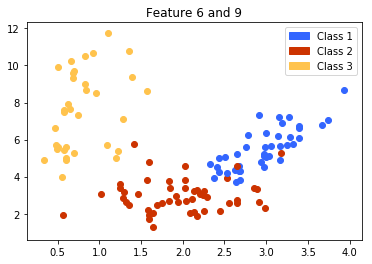

In [3]:
fig, ax = plt.subplots()

ax.set_title("Feature 6 and 9")
data = np.column_stack((train_set[:, features[0]], train_set[:, features[1]]))
plot_coloured(ax, data, train_labels)

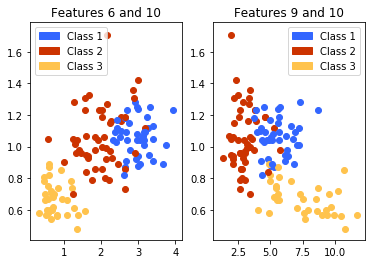

In [4]:
fig, ax = plt.subplots(1, 2)

ax[0].set_title("Features 6 and 10")
data = np.column_stack((train_set[:, features_3d[0]], train_set[:, features_3d[2]]))
plot_coloured(ax[0], data, train_labels)

ax[1].set_title("Features 9 and 10")
data = np.column_stack((train_set[:, features_3d[1]], train_set[:, features_3d[2]]))
plot_coloured(ax[1], data, train_labels)

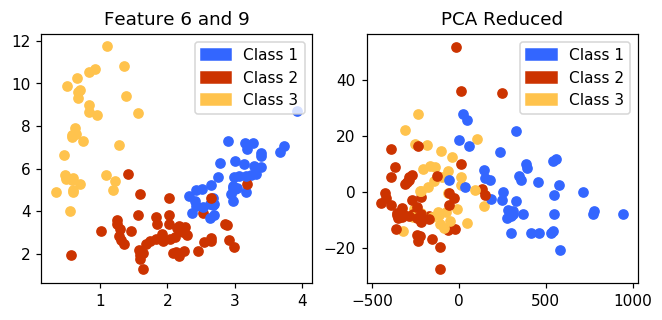

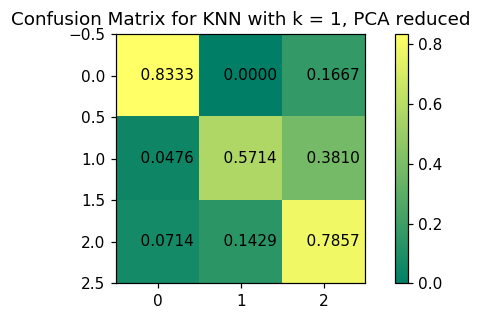

In [5]:
plt.rc('figure', figsize=(7, 3), dpi=110)

pca = PCA(n_components = 2)

train_set_r = pca.fit_transform(train_set)
test_set_r = pca.transform(test_set)

fig, ax = plt.subplots(1, 2)

ax[0].set_title("Feature 6 and 9")
data = np.column_stack((train_set[:, features[0]], train_set[:, features[1]]))
plot_coloured(ax[0], data, train_labels)

ax[1].set_title("PCA Reduced")
plot_coloured(ax[1], train_set_r, train_labels)

fig, ax = plt.subplots()
ax.set_title(f"Confusion Matrix for KNN with k = 1, PCA reduced")
predictions = run_knn(train_set_r, train_labels, test_set_r, 1)

cm = calculate_confusion_matrix(test_labels, predictions)
plot_matrix(cm, ax)

plt.show()

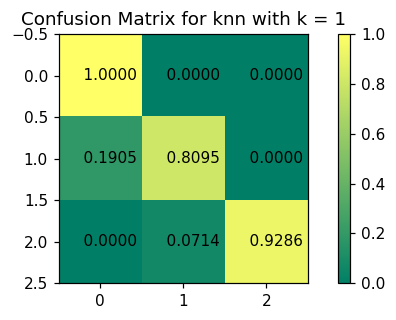

In [6]:
train_set_r = np.column_stack((train_set[:, features[0]], train_set[:, features[1]]))
test_set_r = np.column_stack((test_set[:, features[0]], test_set[:, features[1]]))

fig, ax = plt.subplots()

k = 1
ax.set_title(f"Confusion Matrix for knn with k = 1")
predictions = run_knn(train_set_r, train_labels, test_set_r, k)

cm = calculate_confusion_matrix(test_labels, predictions)
plot_matrix(cm, ax)

plt.show()

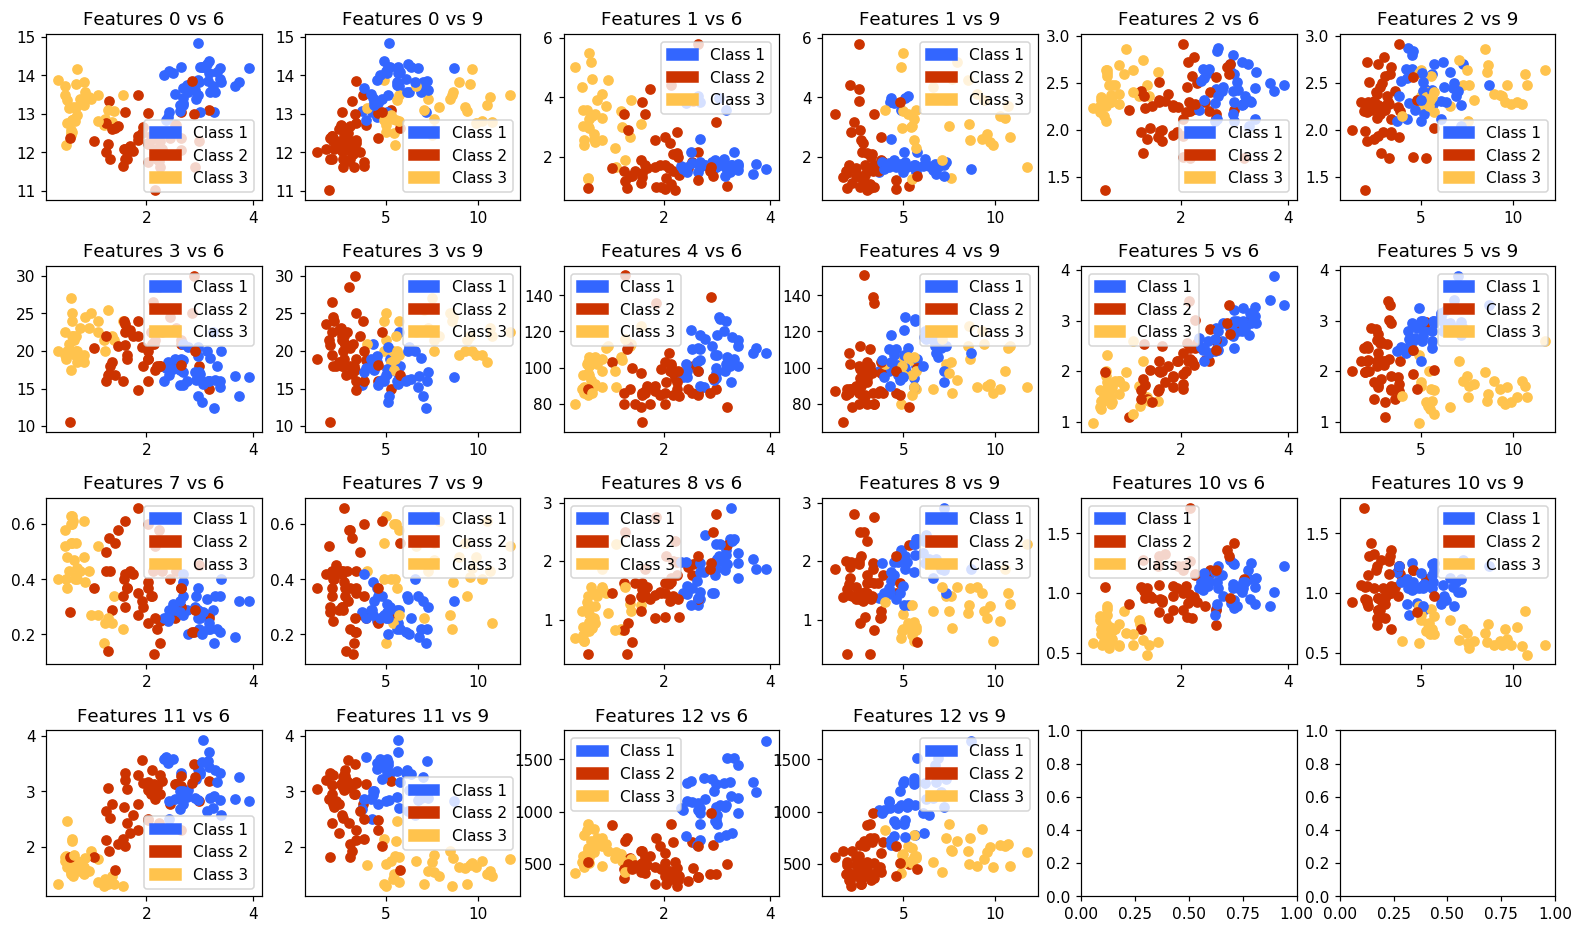

In [7]:
plt.rc('figure', figsize=(14, 8), dpi=110)

n_features = train_set.shape[1]
fig, ax = plt.subplots(4, 6)
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.2, hspace=0.4)

class_1_colour = r'#3366ff'
class_2_colour = r'#cc3300'
class_3_colour = r'#ffc34d'

class_colours = [class_1_colour, class_2_colour, class_3_colour]

x = 0
for i in range(13):
    if i not in features:
        for j in range(2):
            a = x % 6
            b = x // 6

            ax[b, a].set_title('Features {} vs {}'.format(i, features[j]))

            data = np.column_stack((train_set[:, features[j]], train_set[:, i]))
            plot_coloured(ax[b, a], data, train_labels)

            x += 1

plt.show()

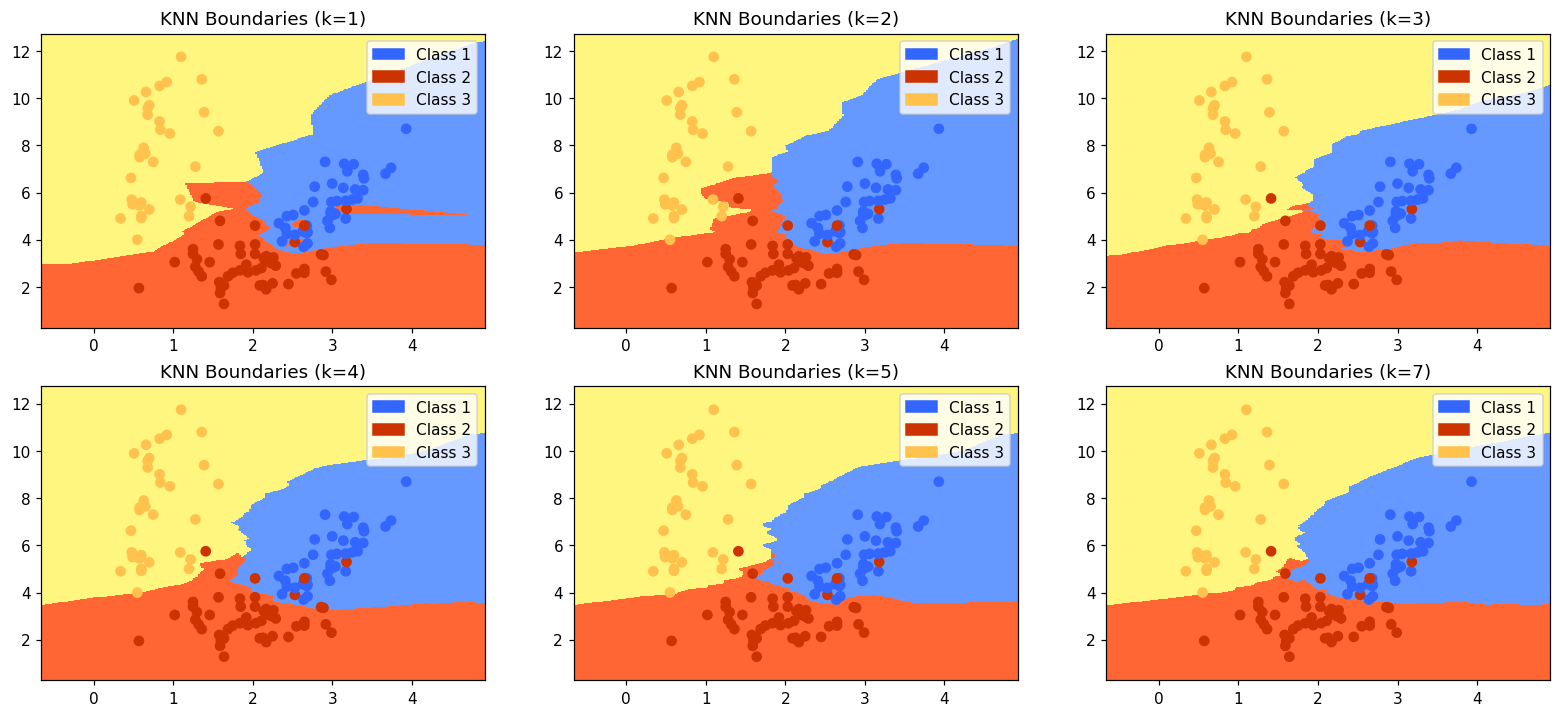

In [9]:
def plot_boundaries(data, labels, k, ax):
    n_neighbors = k

    # import some data to play with
    X = data
    y = labels

    h = .02  # step size in the mesh

    # Create color maps
    cmap_light = ListedColormap(['#6699FF', '#FF6633', '#FFF680'])
    cmap_bold = ListedColormap(class_colours)

    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, "uniform")
    clf.fit(X, y)

    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                        np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(f"KNN Boundaries (k={ n_neighbors })")
    
    handles = [
        mpatches.Patch(color=class_colours[0], label='Class 1'),
        mpatches.Patch(color=class_colours[1], label='Class 2'),
        mpatches.Patch(color=class_colours[2], label='Class 3')
    ]
    ax.legend(handles=handles)
    
train_set_r = np.column_stack((train_set[:, features[0]], train_set[:, features[1]]))
test_set_r = np.column_stack((test_set[:, features[0]], test_set[:, features[1]]))

plt.rc('figure', figsize=(14, 6), dpi=110)
fig, ax = plt.subplots(2, 3)
plt.subplots_adjust(left=0.01, right=0.99, top=0.99, bottom=0.01, wspace=0.2, hspace=0.2)

x = 0
for k in [1, 2, 3, 4, 5, 7]:
    plot_boundaries(train_set_r, train_labels, k, ax[x // 3, x % 3])
    x += 1


plt.show()

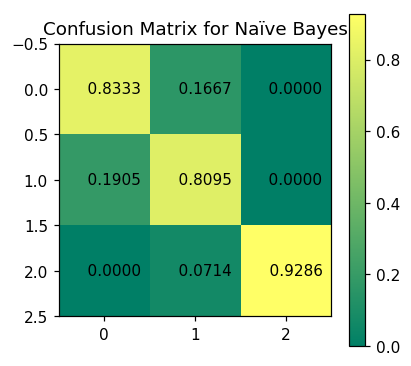

In [22]:
predictions = alternative_classifier(train_set, train_labels, test_set)

fig, ax = plt.subplots()

plt.rc('figure', figsize=(5, 5), dpi=110)

ax.set_title(f"Confusion Matrix for Naïve Bayes")
cm = calculate_confusion_matrix(test_labels, predictions)
plot_matrix(cm, ax)

plt.show()